In [41]:
#The functions use eachother and the constants. It is advisable to paste the whole cell into your code, or save it as .py and import it in. 

import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import interp1d
import numpy.random as npr
import axispi as axp
import timeit

#conversion factor
con1 = 2.56819e-3 #MeV−2,  (DCS MeV-2)/con1 = DCS barns
#----------constants-------------
#Electron and Muon mass squared
mu2 = 105.658**2 #Mev^2
me2 = 0.5110**2 #Mev^2
S = 4*mu2 + 5000 #5000MeV^2 over threshold energy
alpha = 0.007297352 #no unit of measurement

def ab(s):
    #more constants to simplify calculation
    ce = 1-(4*me2/s)
    cu = 1-(4*mu2/s)
    c1 = alpha**2/(4*s)#e**4/(64 * np.pi**2 * s)
    c2 = c1 * cu**(1/2) * ce**(-1/2)

    a = c2 * (1+(4/s)*(me2+mu2))
    b = c2 * (1-(4*mu2/s)) * (1-(4*me2/s))
    return a, b


#differential cross section
def dcs(theta,s):#theta - ejection angle #s - CoM energy squared
    a,b = ab(s)
    return a+b*np.cos(theta)**2

#total cross section
def tcs(s):#s - CoM energy squared
    a,b = ab(s)
    return (4*np.pi/3)*(3*a + b)#in 1/MeV^2

#############################################################################

#probability density function, PDF of ejection angles
def pdf(theta,s):#theta - ejection angle #s - CoM energy squared
    sig = tcs(s)
    DCS = dcs(theta,s)
    return (2*np.pi*np.sin(theta)/sig)*DCS

#Cumulitive Density Function. Probability a THETA sampled is less than theta in the function.
def cdf(theta,s):
    a,b = ab(s)
    sig = tcs(s) 
    return (2*np.pi/sig)*((-np.cos(theta)*(3*a+b*np.cos(theta)**2)*1/3)+ a)

#Theta Generation, Sampling from the PDF, Using Inverse CDF Method
def thetaGen2(howMany,s):#howMany - the number of thetas to generate #s - CoM energy squared
    #generate the lookup table for the inverse function
    theta = np.linspace(0,np.pi,100)
    CDF = [cdf(x,s) for x in theta]
    #thetaPredictor is the inverse CDF brought about using a look up table (theta,CDF) and interpolation
    thetaPredictor = interp1d(CDF, theta, kind = "linear")
    return [float(thetaPredictor(x)) for x in npr.uniform(min(CDF),max(CDF),howMany)]

#Theta Generation, Sampling from the PDF, Using Inverse CDF Method, Considering gaussian beam shape
#Assumes Walters Calculated Nominal Beam energy to penetrate 3cm, and a FWHM of 0.5GeV or 500MeV
def thetaGen3(howMany):#howMany - the number of thetas to generate #s - CoM energy squared
    E_lab_mean = 47571.03
    fwhm = 500 #MeV
    std = fwhm/(2*np.sqrt(2*np.log(2)))
    E_lab = npr.normal(loc = E_lab_mean, scale = std, size = howMany)
    s = 2*me2+2*m_e*E_lab
    theta = np.linspace(0,np.pi,100) #theta range used for inverse CDF calc
    thetas = [] #list to hold generated thetas
    for i in range(howMany):
        CDF = [cdf(x,s[i]) for x in theta]
    #thetaPredictor is the inverse CDF brought about using a look up table (theta,CDF) and interpolation
        thetaPredictor = interp1d(CDF, theta, kind = "linear")
        thetas.append(float(thetaPredictor(npr.uniform(min(CDF),max(CDF)))))
    return thetas

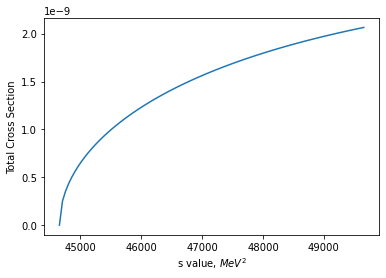

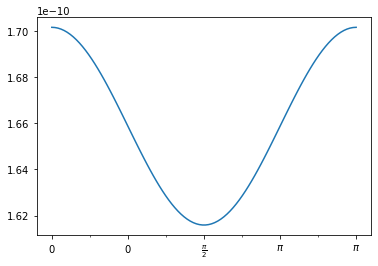

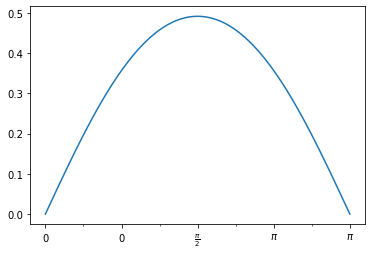

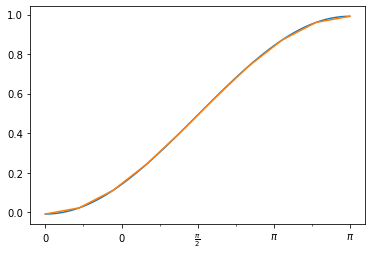

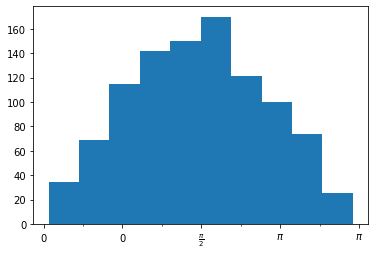

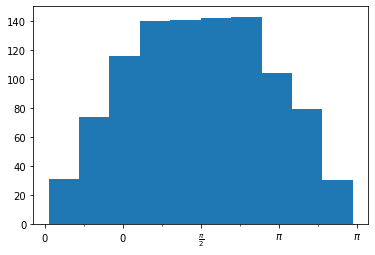

In [42]:
#Example for how to use the above functions. 



Srange = np.linspace(4*mu2,4*mu2+5000,100)
TCS = [tcs(si) for si in Srange] #total cross section as function of energy

theta = np.linspace(0,np.pi,100) #max theta range
DCS = [dcs(th,S) for th in theta] #differential cross section
PDF = [pdf(th,S) for th in theta] #Prob Density Function
CDF = [cdf(th,S) for th in theta] #Cumulative Density Function

#
figTCS = plt.figure()
plt.plot(Srange,TCS)
plt.xlabel(r's value, $MeV^2$')
plt.ylabel('Total Cross Section')

#
figDCS, ax = plt.subplots()
plt.plot(theta,DCS)
ax.xaxis.set_major_locator(plt.MultipleLocator(np.pi / 4))
ax.xaxis.set_minor_locator(plt.MultipleLocator(np.pi / 8))
ax.xaxis.set_major_formatter(plt.FuncFormatter(axp.multiple_formatter()))
#
figPDF, ax = plt.subplots()
plt.plot(theta,PDF)
ax.xaxis.set_major_locator(plt.MultipleLocator(np.pi / 4))
ax.xaxis.set_minor_locator(plt.MultipleLocator(np.pi / 8))
ax.xaxis.set_major_formatter(plt.FuncFormatter(axp.multiple_formatter()))
#


#################################Testing What CDF approximation is best
figCDF, ax = plt.subplots()
plt.plot(theta,CDF)
ax.xaxis.set_major_locator(plt.MultipleLocator(np.pi / 4))
ax.xaxis.set_minor_locator(plt.MultipleLocator(np.pi / 8))
ax.xaxis.set_major_formatter(plt.FuncFormatter(axp.multiple_formatter()))


    
thetaSM = np.linspace(0,np.pi,10)
CDF2 = [cdf(x,S) for x in thetaSM]
#thetaPredictor is the inverse CDF brought about using a look up table (theta,CDF) and interpolation
cdfPredictor = interp1d(thetaSM, CDF2, kind = 'linear')
CDF2 = [cdfPredictor(th) for th in theta]   
plt.plot(theta,CDF2)


#
figThetaGen2 , ax = plt.subplots()
generatedThetas2 = thetaGen2(1000,S)
plt.hist(generatedThetas2)
ax.xaxis.set_major_locator(plt.MultipleLocator(np.pi / 4))
ax.xaxis.set_minor_locator(plt.MultipleLocator(np.pi / 8))
ax.xaxis.set_major_formatter(plt.FuncFormatter(axp.multiple_formatter()))
#
#
figThetaGen3 , ax = plt.subplots()
generatedThetas3 = thetaGen3(1000)
plt.hist(generatedThetas3)
ax.xaxis.set_major_locator(plt.MultipleLocator(np.pi / 4))
ax.xaxis.set_minor_locator(plt.MultipleLocator(np.pi / 8))
ax.xaxis.set_major_formatter(plt.FuncFormatter(axp.multiple_formatter()))




In [38]:
import timeit
def CDFtimeTest(size,kind):
    thetaSM = np.linspace(0,np.pi,size)
    CDF2 = [cdf(x,S) for x in thetaSM]
    #thetaPredictor is the inverse CDF brought about using a look up table (theta,CDF) and interpolation
    cdfPredictor = interp1d(thetaSM, CDF2, kind = kind)
    CDF2 = [cdfPredictor(th) for th in theta]

print("Linear: 5 points")
%timeit CDFtimeTest(5,"linear")

print("Linear: 10 points")
%timeit CDFtimeTest(10,"linear")

print("Linear: 100 points")
%timeit CDFtimeTest(100,"linear")

print("Linear: 1000 points")
%timeit CDFtimeTest(1000,"linear")

print("Quadratic: 5 points")
%timeit CDFtimeTest(5,"quadratic")

print("Quadratic: 10 points")
%timeit CDFtimeTest(10,"quadratic")

print("Quadratic: 100 points")
%timeit CDFtimeTest(100,"quadratic")

print("Quadratic: 1000 points")
%timeit CDFtimeTest(1000,"quadratic")

Linear: 5 points
6.94 ms ± 249 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
Linear: 10 points
7.37 ms ± 411 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
Linear: 100 points
9.1 ms ± 326 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
Linear: 1000 points
28.2 ms ± 1.56 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
Quadratic: 5 points
11.6 ms ± 562 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
Quadratic: 10 points
11.5 ms ± 190 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
Quadratic: 100 points
14.2 ms ± 652 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
Quadratic: 1000 points
31.9 ms ± 164 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
